In [1]:
import sys
from os.path import dirname, abspath

sys.path.append(dirname(abspath('')))

from scipy.stats import beta, uniform
import numpy as np

from pyquantifier.data import Item, Dataset
from pyquantifier.distributions import MultinomialDUD, MixtureCUD, IntrinsicJointDistribution, ExtrinsicJointDistribution
from pyquantifier.calibration_curve import PlattScaling
from pyquantifier.plot import *

plt.rcParams.update({'font.size': 10})

## Strong and weak classifier figures

In [2]:
def plot_class_conditional_densities(alpha_p, beta_p, alpha_n, beta_n, lam, figname='', ax=None):
    labels = ['pos', 'neg']

    pos_cud = MixtureCUD(components=[beta(alpha_p, beta_p), uniform(0, 1)], weights=[lam, 1-lam])
    neg_cud = MixtureCUD(components=[beta(alpha_n, beta_n), uniform(0, 1)], weights=[lam, 1-lam])

    class_conditional_densities = {'pos': pos_cud, 'neg': neg_cud}

    if ax is None:
        ax = prepare_canvas()

    for label in labels:
        class_conditional_densities[label].plot(ax=ax, num_bin=1000,
                                                color=ColorPalette[label])

    # hide x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    # hide x and y labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    if figname:
        plt.savefig(f'figs/{figname}', bbox_inches='tight')

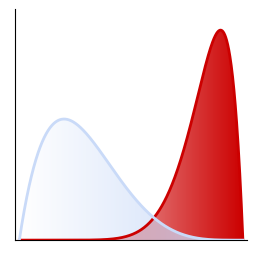

In [3]:
plot_class_conditional_densities(alpha_p=10, beta_p=2, alpha_n=2, beta_n=5, lam=1, figname='table3_row1_stable.pdf')

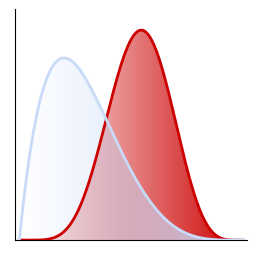

In [4]:
plot_class_conditional_densities(alpha_p=7, beta_p=6, alpha_n=2, beta_n=5, lam=1, figname='table3_row2_stable.pdf')

In [5]:
def plot_calibration_curve(w, b, figname):
    ax = prepare_canvas()

    strong_calibration_curve = PlattScaling()
    strong_calibration_curve.set_params(w=w, b=b)

    strong_calibration_curve.plot(ax=ax)

    # hide x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    # hide x and y labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.savefig(f'figs/{figname}', bbox_inches='tight')

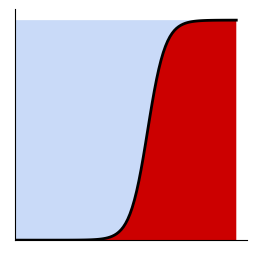

In [6]:
plot_calibration_curve(25, -15, 'table3_row3_stable.pdf')

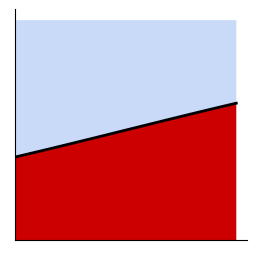

In [7]:
plot_calibration_curve(1, -0.5, 'table3_row4_stable.pdf')

## Helper functions

### select and annotate function, compute GT function, used for two scenarios

In [8]:
def select_and_annotate_dataset(dataset, gt_label_dict, n, strategy):
    # strategy options are 'random', 'uniform', 'neyman'
    selected_dataset, selection_weights = dataset.select_sample_for_annotation(n=n, strategy=strategy, bins=10)
    annotated_labels = [gt_label_dict[uid] for uid in selected_dataset.df['uid'].values.tolist()]
    selected_dataset.annotate_sample(annotated_labels)
    return selected_dataset, selection_weights

In [9]:
def compute_ground_truth_prevalence(gt_label_dict):
    return len([label for label in gt_label_dict.values() if label == 'pos']) / len(gt_label_dict)

In [10]:
def compute_no_calibration_prevalence(dataset):
    return dataset.df['pos'].sum() / len(dataset.df)

In [11]:
def bootstrap_estimation_calibration(base_dataset, base_gt_label_dict, num_annotated_items, sampling_strategy, num_bin=10, inverse_weight=False, num_bootstrap=1000):
    print(f'>> base dataset ground truth: {compute_ground_truth_prevalence(base_gt_label_dict):.2%}')
    print(f'>> base dataset no calibration: {compute_no_calibration_prevalence(base_dataset):.2%}')

    mixture_model_prevalence_list = []
    probabilistic_estimator_prevalence_list = []

    for i in range(num_bootstrap):
        calibration_sample, selection_weights = select_and_annotate_dataset(base_dataset, base_gt_label_dict, n=num_annotated_items, strategy=sampling_strategy)
        if inverse_weight:
            calibration_sample.update_dataset_model(num_bin=num_bin, selection_weights=selection_weights)
            # calibration_sample.profile_dataset(num_bin=10, selection_weights=selection_weights)
        else:
            calibration_sample.update_dataset_model(num_bin=num_bin)
            # calibration_sample.profile_dataset(num_bin=10)
        
        mixture_model_prevalence_list.append(base_dataset.intrinsic_estimate(class_conditional_densities=calibration_sample.class_conditional_densities))
        probabilistic_estimator_prevalence_list.append(base_dataset.extrinsic_estimate(calibration_curve=calibration_sample.calibration_curve))
        print(f'bootstrap {i+1}/{num_bootstrap} done')
        print(f'{mixture_model_prevalence_list[-1]:.2%} {probabilistic_estimator_prevalence_list[-1]:.2%}')

    print(f'prevalence estimation using mixture model: {np.mean(mixture_model_prevalence_list):.2%} $\pm$ {np.percentile(mixture_model_prevalence_list, 2.5):.2%}, {np.percentile(mixture_model_prevalence_list, 97.5):.2%}')
    print(f'prevalence estimation using probabilistic estimator: {np.mean(probabilistic_estimator_prevalence_list):.2%} $\pm$ {np.percentile(probabilistic_estimator_prevalence_list, 2.5):.2%}, {np.percentile(probabilistic_estimator_prevalence_list, 97.5):.2%}')
    # return mixture_model_prevalence_list, probabilistic_estimator_prevalence_list

# print('prevalence if using the varying TPR and FPR of purposive selected calibration sample')

In [12]:
def bootstrap_estimation_extrapolation(base_dataset, base_gt_label_dict, target_dataset, target_gt_label_dict, num_annotated_items, sampling_strategy, num_bin=10, inverse_weight=True, num_bootstrap=1000):
    print(f'>> target dataset ground truth: {compute_ground_truth_prevalence(target_gt_label_dict):.2%}')
    print(f'>> target dataset no calibration: {compute_no_calibration_prevalence(target_dataset):.2%}')

    mixture_model_prevalence_list = []
    probabilistic_estimator_prevalence_list = []

    for i in range(num_bootstrap):
        calibration_sample, selection_weights = select_and_annotate_dataset(base_dataset, base_gt_label_dict, n=num_annotated_items, strategy=sampling_strategy)
        if inverse_weight:
            calibration_sample.update_dataset_model(num_bin=num_bin, selection_weights=selection_weights)
            # calibration_sample.profile_dataset(num_bin=10, selection_weights=selection_weights)
        else:
            calibration_sample.update_dataset_model(num_bin=num_bin)
            # calibration_sample.profile_dataset(num_bin=10)
        
        mixture_model_prevalence_list.append(target_dataset.intrinsic_estimate(class_conditional_densities=calibration_sample.class_conditional_densities))
        probabilistic_estimator_prevalence_list.append(target_dataset.extrinsic_estimate(calibration_curve=calibration_sample.calibration_curve))
        print(f'bootstrap {i+1}/{num_bootstrap} done')
        print(f'{mixture_model_prevalence_list[-1]:.2%} {probabilistic_estimator_prevalence_list[-1]:.2%}')

    print(f'prevalence estimation using mixture model: {np.mean(mixture_model_prevalence_list):.2%} $\pm$ {np.percentile(mixture_model_prevalence_list, 2.5):.2%}, {np.percentile(mixture_model_prevalence_list, 97.5):.2%}')
    print(f'prevalence estimation using probabilistic estimator: {np.mean(probabilistic_estimator_prevalence_list):.2%} $\pm$ {np.percentile(probabilistic_estimator_prevalence_list, 2.5):.2%}, {np.percentile(probabilistic_estimator_prevalence_list, 97.5):.2%}')
    # return mixture_model_prevalence_list, probabilistic_estimator_prevalence_list

# print('prevalence if using the varying TPR and FPR of purposive selected calibration sample')

### Intrinsic data generator

In [13]:
def generate_intrinsic_dataset(n, alpha_p, beta_p, alpha_n, beta_n, lam, pr_pos):
    all_labels = ['pos', 'neg']

    # Generate 10000 items which pos scores follow the mixture distribution
    num_pos = int(n * pr_pos)
    num_neg = n - num_pos

    pos_rv = MixtureCUD(components=[beta(alpha_p, beta_p), uniform(0, 1)], weights=[lam, 1-lam])
    neg_rv = MixtureCUD(components=[beta(alpha_n, beta_n), uniform(0, 1)], weights=[lam, 1-lam])

    simulated_pos_scores = pos_rv.generate_data(num_pos)
    simulated_neg_scores = neg_rv.generate_data(num_neg)

    items = []
    gt_label_dict = {}
    uid = 1
    for label, scores in zip(all_labels, [simulated_pos_scores, simulated_neg_scores]):
        for idx, score in enumerate(scores):
            item = Item(uid=uid, labels=all_labels, probs=[score, 1-score])
            items.append(item)

            gt_label_dict[item.uid] = label
            uid += 1

    dataset = Dataset(items=items, labels=all_labels)
    dataset.df.shape
    return dataset, gt_label_dict

In [14]:
dataset_size = 20000
num_annotation = 2000
num_bootstrap = 1000

base_intrinsic_strong_dataset, base_intrinsic_strong_gt_label_dict = \
    generate_intrinsic_dataset(n=dataset_size, alpha_p=10, beta_p=2, alpha_n=2, beta_n=5, lam=1, pr_pos=0.2)

target_intrinsic_strong_dataset, target_intrinsic_strong_gt_label_dict = \
    generate_intrinsic_dataset(n=dataset_size, alpha_p=10, beta_p=2, alpha_n=2, beta_n=5, lam=1, pr_pos=0.6)

base_intrinsic_weak_dataset, base_intrinsic_weak_gt_label_dict = \
    generate_intrinsic_dataset(n=dataset_size, alpha_p=7, beta_p=6, alpha_n=2, beta_n=5, lam=0.9, pr_pos=0.2)

target_intrinsic_weak_dataset, target_intrinsic_weak_gt_label_dict = \
    generate_intrinsic_dataset(n=dataset_size, alpha_p=7, beta_p=6, alpha_n=2, beta_n=5, lam=0.9, pr_pos=0.6)


In [15]:
print(f'>> base intrinsic strong dataset no calibration: {compute_no_calibration_prevalence(base_intrinsic_strong_dataset):.2%}')
print(f'>> target intrinsic strong dataset no calibration: {compute_no_calibration_prevalence(target_intrinsic_strong_dataset):.2%}')
print(f'>> base intrinsic weak dataset no calibration: {compute_no_calibration_prevalence(base_intrinsic_weak_dataset):.2%}')
print(f'>> base intrinsic weak dataset no calibration: {compute_no_calibration_prevalence(target_intrinsic_weak_dataset):.2%}')


>> base intrinsic strong dataset no calibration: 39.51%
>> target intrinsic strong dataset no calibration: 61.43%
>> base intrinsic weak dataset no calibration: 35.04%
>> base intrinsic weak dataset no calibration: 44.44%


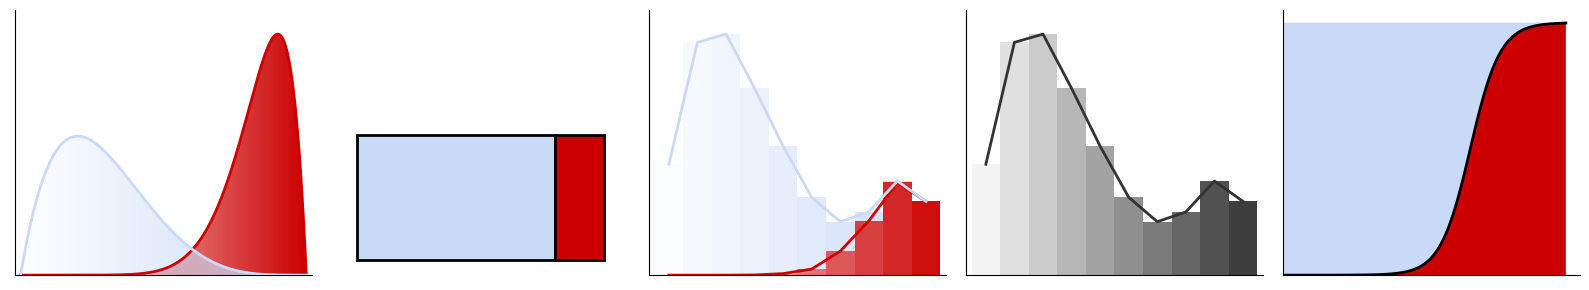

In [16]:
base_intrinsic_strong_all_dataset, _ = select_and_annotate_dataset(base_intrinsic_strong_dataset, base_intrinsic_strong_gt_label_dict, n=dataset_size, strategy='random')
axes = base_intrinsic_strong_all_dataset.profile_dataset(num_bin=10)

# clear axes[0]
axes[0].clear()
plot_class_conditional_densities(alpha_p=10, beta_p=2, alpha_n=2, beta_n=5, lam=1, ax=axes[0])
plt.savefig('figs/table2_row1.pdf', bbox_inches='tight')
plt.savefig('figs/table3_row1_base.pdf', bbox_inches='tight')

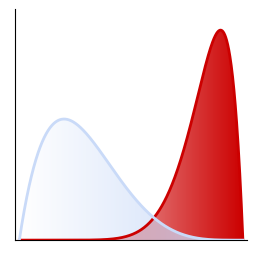

In [17]:
ax = prepare_canvas()
plot_class_conditional_densities(alpha_p=10, beta_p=2, alpha_n=2, beta_n=5, lam=1, ax=ax)

plt.savefig('figs/table3_row1_stable.pdf', bbox_inches='tight')

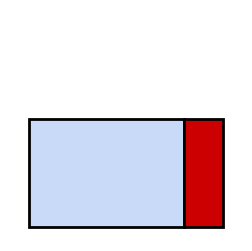

In [18]:
ax = prepare_canvas()
base_intrinsic_strong_all_dataset.label_distribution.plot(ax=ax, ci=False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
plt.savefig('figs/table3_row1_shift_b.pdf', bbox_inches='tight')

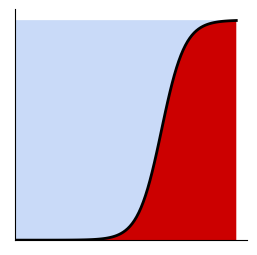

In [19]:
ax = prepare_canvas()
base_intrinsic_strong_all_dataset.calibration_curve.plot(ax=ax, show_diagonal=False)

# hide x and y ticks
ax.set_xticks([])
ax.set_yticks([])
# hide x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('figs/table3_row1_inferred_b.pdf', bbox_inches='tight')

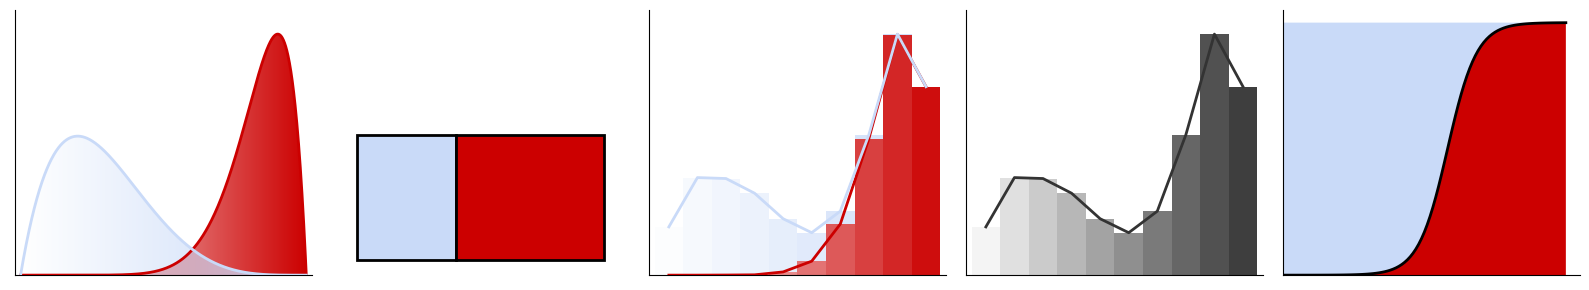

In [20]:
target_intrinsic_strong_all_dataset, _ = select_and_annotate_dataset(target_intrinsic_strong_dataset, target_intrinsic_strong_gt_label_dict, n=dataset_size, strategy='random')
axes = target_intrinsic_strong_all_dataset.profile_dataset(num_bin=10)

# clear axes[0]
axes[0].clear()
plot_class_conditional_densities(alpha_p=10, beta_p=2, alpha_n=2, beta_n=5, lam=1, ax=axes[0])
plt.savefig('figs/table3_row1_target.pdf', bbox_inches='tight')

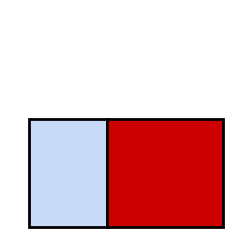

In [21]:
ax = prepare_canvas()
target_intrinsic_strong_all_dataset.label_distribution.plot(ax=ax, ci=False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
plt.savefig('figs/table3_row1_shift_t.pdf', bbox_inches='tight')

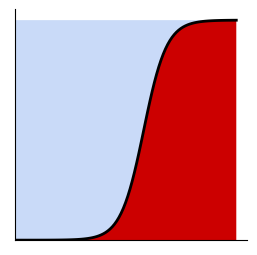

In [22]:
ax = prepare_canvas()
target_intrinsic_strong_all_dataset.calibration_curve.plot(ax=ax, show_diagonal=False)

# hide x and y ticks
ax.set_xticks([])
ax.set_yticks([])
# hide x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('figs/table3_row1_inferred_t.pdf', bbox_inches='tight')

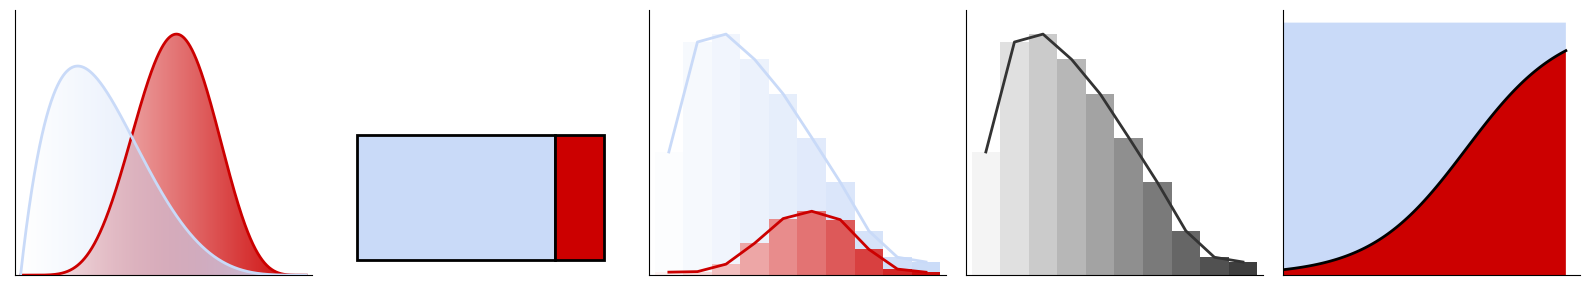

In [23]:
base_intrinsic_weak_all_dataset, _ = select_and_annotate_dataset(base_intrinsic_weak_dataset, base_intrinsic_weak_gt_label_dict, n=dataset_size, strategy='random')
axes = base_intrinsic_weak_all_dataset.profile_dataset(num_bin=10)

# clear axes[0]
axes[0].clear()
plot_class_conditional_densities(alpha_p=7, beta_p=6, alpha_n=2, beta_n=5, lam=1, ax=axes[0])
plt.savefig('figs/table2_row2.pdf', bbox_inches='tight')
plt.savefig('figs/table3_row2_base.pdf', bbox_inches='tight')

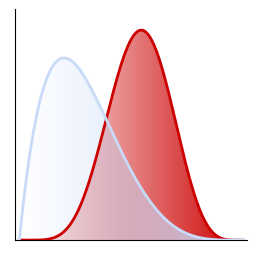

In [24]:
ax = prepare_canvas()
plot_class_conditional_densities(alpha_p=7, beta_p=6, alpha_n=2, beta_n=5, lam=1, ax=ax)

plt.savefig('figs/table3_row2_stable.pdf', bbox_inches='tight')

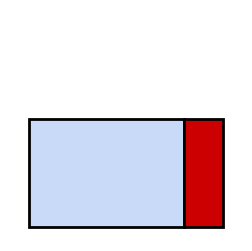

In [25]:
ax = prepare_canvas()
base_intrinsic_weak_all_dataset.label_distribution.plot(ax=ax, ci=False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
plt.savefig('figs/table3_row2_shift_b.pdf', bbox_inches='tight')

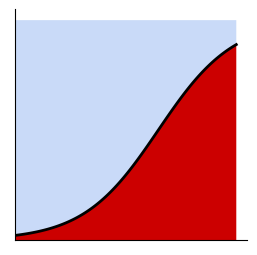

In [26]:
ax = prepare_canvas()
base_intrinsic_weak_all_dataset.calibration_curve.plot(ax=ax, show_diagonal=False)

# hide x and y ticks
ax.set_xticks([])
ax.set_yticks([])
# hide x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('figs/table3_row2_inferred_b.pdf', bbox_inches='tight')

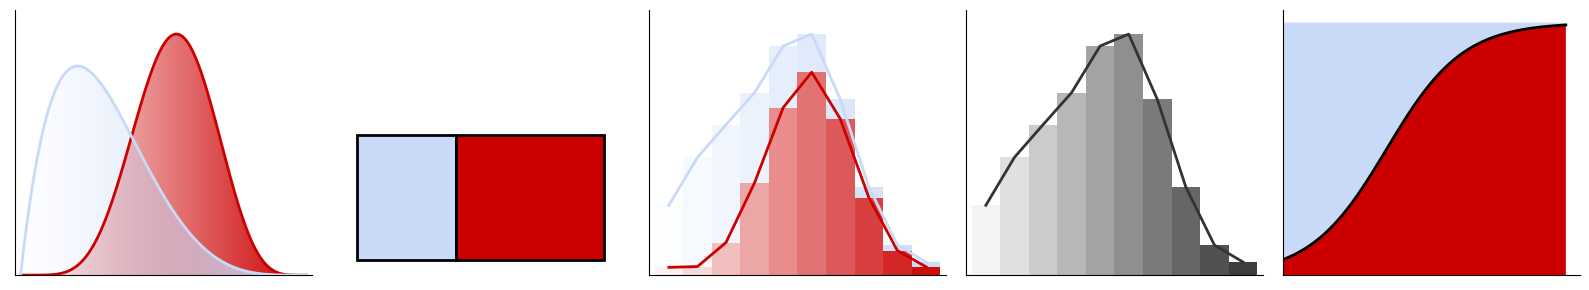

In [27]:
target_intrinsic_weak_all_dataset, _ = select_and_annotate_dataset(target_intrinsic_weak_dataset, target_intrinsic_weak_gt_label_dict, n=dataset_size, strategy='random')
axes = target_intrinsic_weak_all_dataset.profile_dataset(num_bin=10)

# clear axes[0]
axes[0].clear()
plot_class_conditional_densities(alpha_p=7, beta_p=6, alpha_n=2, beta_n=5, lam=1, ax=axes[0])
plt.savefig('figs/table3_row2_target.pdf', bbox_inches='tight')

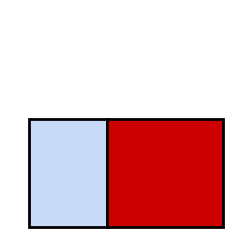

In [28]:
ax = prepare_canvas()
target_intrinsic_weak_all_dataset.label_distribution.plot(ax=ax, ci=False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
plt.savefig('figs/table3_row2_shift_t.pdf', bbox_inches='tight')

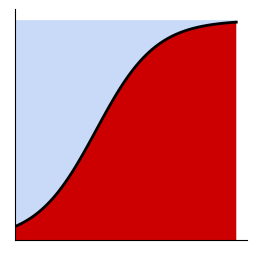

In [29]:
ax = prepare_canvas()
target_intrinsic_weak_all_dataset.calibration_curve.plot(ax=ax, show_diagonal=False)

# hide x and y ticks
ax.set_xticks([])
ax.set_yticks([])
# hide x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('figs/table3_row2_inferred_t.pdf', bbox_inches='tight')

original_bin_dict {2: 3818, 1: 3687, 3: 2959, 4: 2041, 0: 1757, 8: 1490, 5: 1233, 9: 1168, 7: 1001, 6: 846}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}


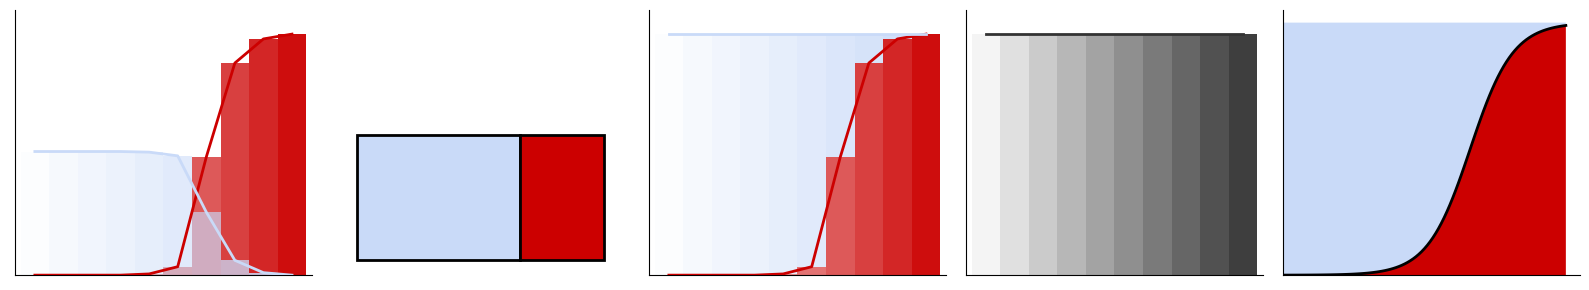

In [30]:
base_intrinsic_strong_sample_dataset, _ = select_and_annotate_dataset(base_intrinsic_strong_dataset, base_intrinsic_strong_gt_label_dict, n=num_annotation, strategy='uniform')
base_intrinsic_strong_sample_dataset.profile_dataset(num_bin=10)

plt.savefig('figs/sample_five_dists.pdf', bbox_inches='tight')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

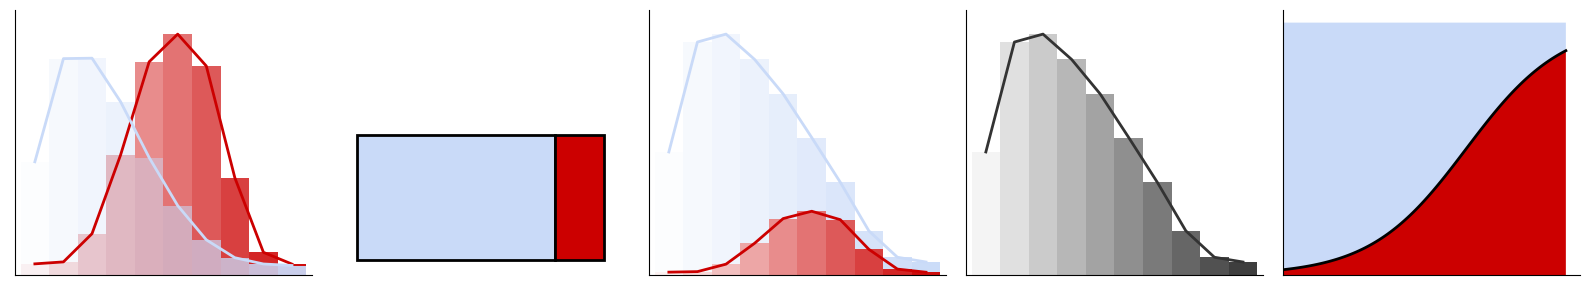

In [31]:
base_intrinsic_weak_all_dataset, _ = select_and_annotate_dataset(base_intrinsic_weak_dataset, base_intrinsic_weak_gt_label_dict, n=dataset_size, strategy='random')
base_intrinsic_weak_all_dataset.profile_dataset(num_bin=10)

### Extrinsic data generator

In [32]:
def generate_extrinsic_dataset(n, w, b, alpha_1, beta_1, alpha_2, beta_2, lambda_1, lambda_2):
    all_labels = ['pos', 'neg']

    # Generate 10000 items which pos scores follow the mixture distribution
    mix_rv = MixtureCUD(components=[beta(alpha_1, beta_1), beta(alpha_2, beta_2,)], weights=[lambda_1, lambda_2])
    simulated_pos_scores = mix_rv.generate_data(n)

    calibration_curve = PlattScaling()
    calibration_curve.set_params(w, b)

    items = []
    gt_label_dict = {}
    for idx, pos_score in enumerate(simulated_pos_scores):
        item = Item(uid=idx+1, labels=all_labels, probs=[pos_score, 1-pos_score])
        items.append(item)

        calibrated_pos_score = calibration_curve.get_calibrated_prob(pos_score)[0]
        gt_label_dict[item.uid] = np.random.choice(all_labels, p=[calibrated_pos_score, 1-calibrated_pos_score])

    dataset = Dataset(items=items, labels=all_labels)
    dataset.df.shape
    return dataset, gt_label_dict

In [33]:
dataset_size = 20000
num_annotated_items = 2000
num_bootstrap = 1000

base_extrinsic_strong_dataset, base_extrinsic_strong_gt_label_dict = \
    generate_extrinsic_dataset(n=dataset_size, w=25, b=-15, alpha_1=10, beta_1=2, alpha_2=2, beta_2=5, lambda_1=0.2, lambda_2=0.8)

target_extrinsic_strong_dataset, target_extrinsic_strong_gt_label_dict = \
    generate_extrinsic_dataset(n=dataset_size, w=25, b=-15, alpha_1=10, beta_1=2, alpha_2=2, beta_2=5, lambda_1=0.6, lambda_2=0.4)

base_extrinsic_weak_dataset, base_extrinsic_weak_gt_label_dict = \
    generate_extrinsic_dataset(n=dataset_size, w=0.5, b=-1, alpha_1=10, beta_1=2, alpha_2=2, beta_2=5, lambda_1=0.2, lambda_2=0.8)

target_extrinsic_weak_dataset, target_extrinsic_weak_gt_label_dict = \
    generate_extrinsic_dataset(n=dataset_size, w=0.5, b=-1, alpha_1=10, beta_1=2, alpha_2=2, beta_2=5, lambda_1=0.6, lambda_2=0.4)

In [34]:
print(f'>> base extrinsic strong dataset no calibration: {compute_no_calibration_prevalence(base_extrinsic_strong_dataset):.2%}')
print(f'>> target extrinsic strong dataset no calibration: {compute_no_calibration_prevalence(target_extrinsic_strong_dataset):.2%}')
print(f'>> base extrinsic weak dataset no calibration: {compute_no_calibration_prevalence(base_extrinsic_weak_dataset):.2%}')
print(f'>> target extrinsic weak dataset no calibration: {compute_no_calibration_prevalence(target_extrinsic_weak_dataset):.2%}')

>> base extrinsic strong dataset no calibration: 39.77%
>> target extrinsic strong dataset no calibration: 61.78%
>> base extrinsic weak dataset no calibration: 39.64%
>> target extrinsic weak dataset no calibration: 61.47%


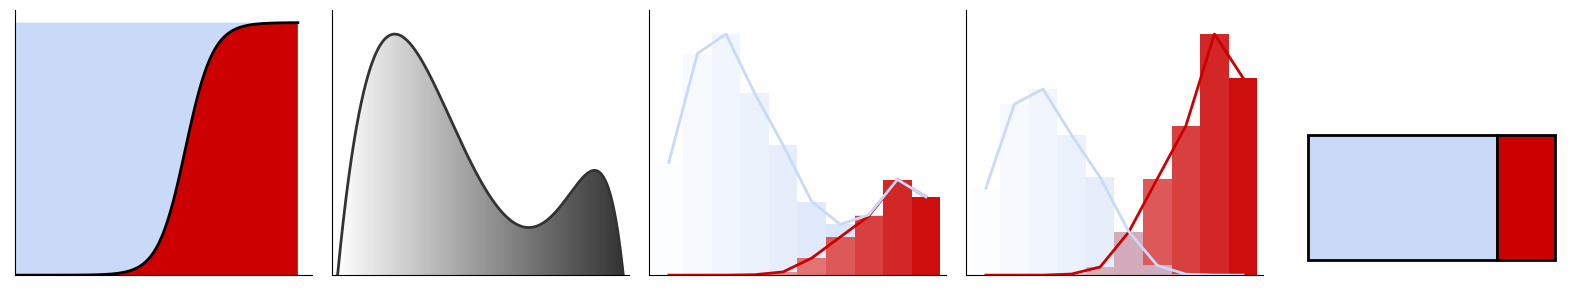

In [35]:
base_extrinsic_strong_all_dataset, _ = select_and_annotate_dataset(base_extrinsic_strong_dataset, base_extrinsic_strong_gt_label_dict, n=dataset_size, strategy='random')
axes = base_extrinsic_strong_all_dataset.profile_dataset_rev(num_bin=10)

# clear axes[1]
axes[1].clear()
MixtureCUD(components=[beta(10, 2), beta(2, 5)], weights=[0.2, 0.8]).plot(ax=axes[1], num_bin=1000)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.savefig('figs/table2_row3.pdf', bbox_inches='tight')
plt.savefig('figs/table3_row3_base.pdf', bbox_inches='tight')

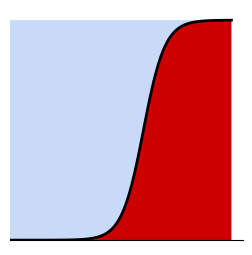

In [36]:
ax = prepare_canvas()
base_extrinsic_strong_all_dataset.calibration_curve.plot(ax=ax, ci=False)
ax.spines['left'].set_visible(False)

# hide x and y ticks
ax.set_xticks([])
ax.set_yticks([])
# hide x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('figs/table3_row3_stable.pdf', bbox_inches='tight')

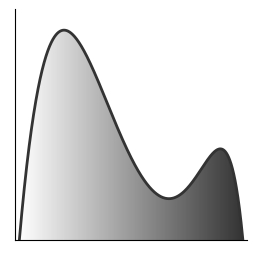

In [37]:
ax = prepare_canvas()
MixtureCUD(components=[beta(10, 2), beta(2, 5)], weights=[0.2, 0.8]).plot(ax=ax, num_bin=1000)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig('figs/table3_row3_shift_b.pdf', bbox_inches='tight')

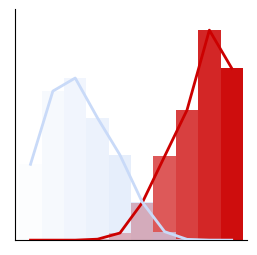

In [38]:
ax = prepare_canvas()
for label in ['pos', 'neg']:
    base_extrinsic_strong_all_dataset.class_conditional_densities[label].plot(ax=ax, color=ColorPalette[label])

# hide x and y ticks
ax.set_xticks([])
ax.set_yticks([])
# hide x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('figs/table3_row3_inferred_b.pdf', bbox_inches='tight')

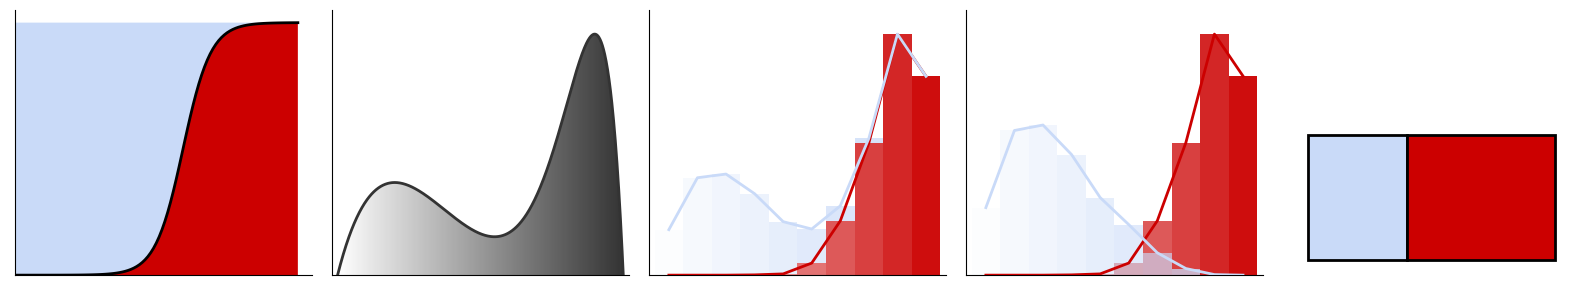

In [39]:
target_extrinsic_strong_all_dataset, _ = select_and_annotate_dataset(target_extrinsic_strong_dataset, target_extrinsic_strong_gt_label_dict, n=dataset_size, strategy='random')
axes= target_extrinsic_strong_all_dataset.profile_dataset_rev(num_bin=10)

# clear axes[1]
axes[1].clear()
MixtureCUD(components=[beta(10, 2), beta(2, 5)], weights=[0.6, 0.4]).plot(ax=axes[1], num_bin=1000)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.savefig('figs/table3_row3_target.pdf', bbox_inches='tight')

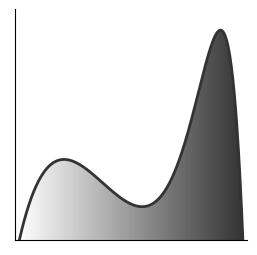

In [40]:
ax = prepare_canvas()
MixtureCUD(components=[beta(10, 2), beta(2, 5)], weights=[0.6, 0.4]).plot(ax=ax, num_bin=1000)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig('figs/table3_row3_shift_t.pdf', bbox_inches='tight')

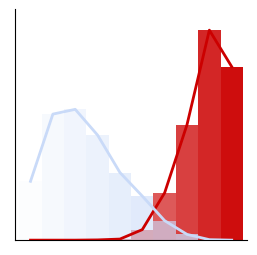

In [41]:
ax = prepare_canvas()
for label in ['pos', 'neg']:
    target_extrinsic_strong_all_dataset.class_conditional_densities[label].plot(ax=ax, color=ColorPalette[label])

# hide x and y ticks
ax.set_xticks([])
ax.set_yticks([])
# hide x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('figs/table3_row3_inferred_t.pdf', bbox_inches='tight')

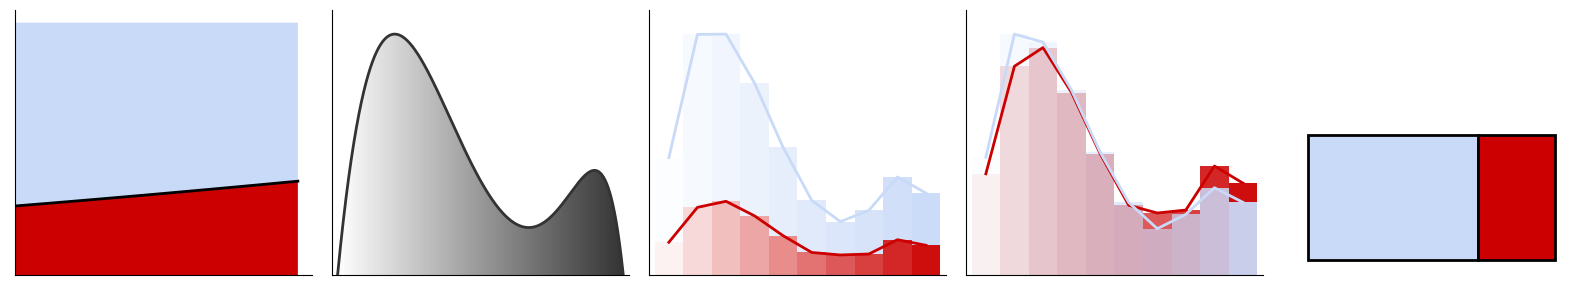

In [42]:
base_extrinsic_weak_all_dataset, _ = select_and_annotate_dataset(base_extrinsic_weak_dataset, base_extrinsic_weak_gt_label_dict, n=dataset_size, strategy='random')
axes = base_extrinsic_weak_all_dataset.profile_dataset_rev(num_bin=10)

# clear axes[1]
axes[1].clear()
MixtureCUD(components=[beta(10, 2), beta(2, 5)], weights=[0.2, 0.8]).plot(ax=axes[1], num_bin=1000)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.savefig('figs/table2_row4.pdf', bbox_inches='tight')
plt.savefig('figs/table3_row4_base.pdf', bbox_inches='tight')

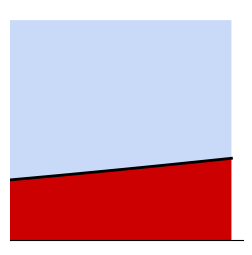

In [43]:
ax = prepare_canvas()
base_extrinsic_weak_all_dataset.calibration_curve.plot(ax=ax, ci=False)
ax.spines['left'].set_visible(False)

# hide x and y ticks
ax.set_xticks([])
ax.set_yticks([])
# hide x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('figs/table3_row4_stable.pdf', bbox_inches='tight')

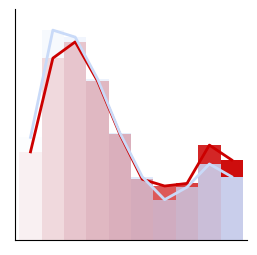

In [44]:
ax = prepare_canvas()
for label in ['pos', 'neg']:
    base_extrinsic_weak_all_dataset.class_conditional_densities[label].plot(ax=ax, color=ColorPalette[label])

# hide x and y ticks
ax.set_xticks([])
ax.set_yticks([])
# hide x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('figs/table3_row4_inferred_b.pdf', bbox_inches='tight')

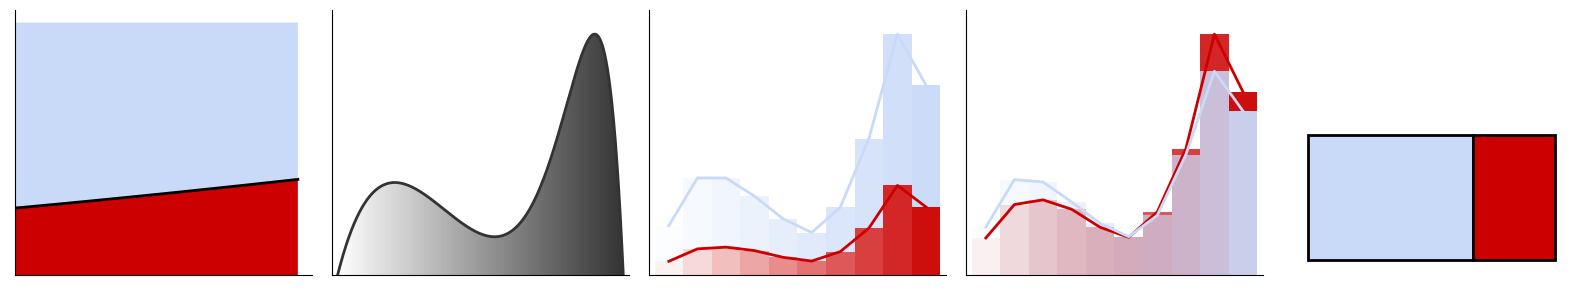

In [45]:
target_extrinsic_weak_all_dataset, _ = select_and_annotate_dataset(target_extrinsic_weak_dataset, target_extrinsic_weak_gt_label_dict, n=dataset_size, strategy='random')
axes = target_extrinsic_weak_all_dataset.profile_dataset_rev(num_bin=10)

# clear axes[1]
axes[1].clear()
MixtureCUD(components=[beta(10, 2), beta(2, 5)], weights=[0.6, 0.4]).plot(ax=axes[1], num_bin=1000)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.savefig('figs/table3_row4_target.pdf', bbox_inches='tight')

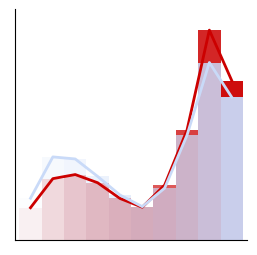

In [46]:
ax = prepare_canvas()
for label in ['pos', 'neg']:
    target_extrinsic_weak_all_dataset.class_conditional_densities[label].plot(ax=ax, color=ColorPalette[label])

# hide x and y ticks
ax.set_xticks([])
ax.set_yticks([])
# hide x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('figs/table3_row4_inferred_t.pdf', bbox_inches='tight')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

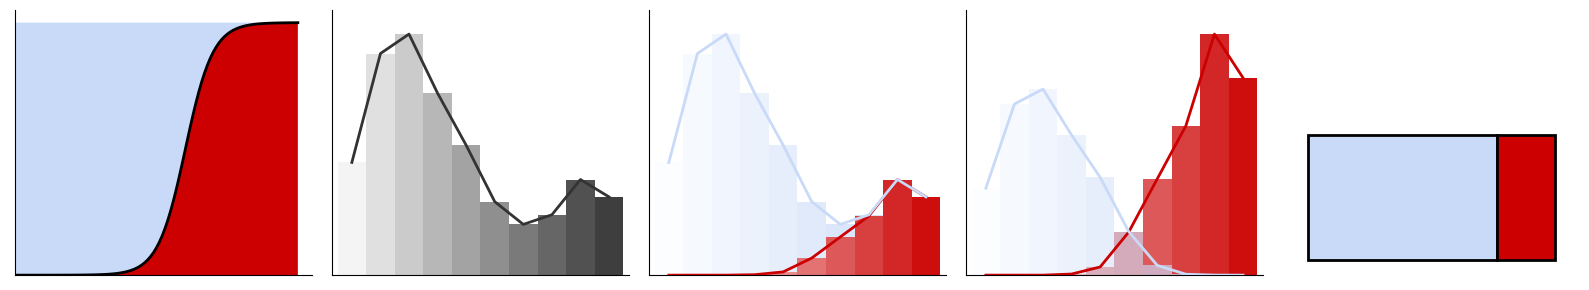

In [47]:
base_extrinsic_strong_all_dataset, _ = select_and_annotate_dataset(base_extrinsic_strong_dataset, base_extrinsic_strong_gt_label_dict, n=dataset_size, strategy='random')
base_extrinsic_strong_all_dataset.profile_dataset_rev(num_bin=10)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

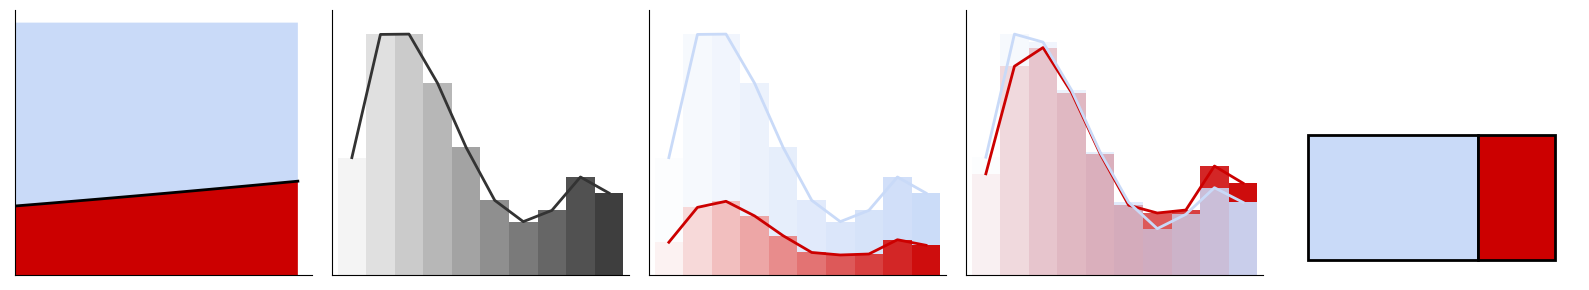

In [48]:
base_extrinsic_weak_all_dataset, _ = select_and_annotate_dataset(base_extrinsic_weak_dataset, base_extrinsic_weak_gt_label_dict, n=dataset_size, strategy='random')
base_extrinsic_weak_all_dataset.profile_dataset_rev(num_bin=10)

## Calibration phase (Table 2)

### Intrinsic data generation

In [49]:
# Table 2 row 1, 3
bootstrap_estimation_calibration(base_intrinsic_strong_dataset, base_intrinsic_strong_gt_label_dict, num_annotated_items=num_annotation, sampling_strategy='uniform', num_bin=10, inverse_weight=False, num_bootstrap=num_bootstrap)

>> base dataset ground truth: 20.00%
>> base dataset no calibration: 39.51%
original_bin_dict {2: 3818, 1: 3687, 3: 2959, 4: 2041, 0: 1757, 8: 1490, 5: 1233, 9: 1168, 7: 1001, 6: 846}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 1/1000 done
18.00% 20.33%
original_bin_dict {2: 3818, 1: 3687, 3: 2959, 4: 2041, 0: 1757, 8: 1490, 5: 1233, 9: 1168, 7: 1001, 6: 846}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 2/1000 done
19.00% 20.91%
original_bin_dict {2: 3818, 1: 3687, 3: 2959, 4: 2041, 0: 1757, 8: 1490, 5: 1233, 9: 1168, 7: 1001, 6: 846}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 3/1000 done
18.00% 20.29%
original_bin_dict {2: 3818, 1: 3687, 3: 2959, 4: 2041, 0: 1757, 8: 1490, 5: 1233, 9: 1168, 7: 1001, 6: 846}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 

In [50]:
# Table 2 row 4, 6
bootstrap_estimation_calibration(base_intrinsic_weak_dataset, base_intrinsic_weak_gt_label_dict, num_annotated_items=num_annotation, sampling_strategy='uniform', num_bin=10, inverse_weight=False, num_bootstrap=num_bootstrap)

>> base dataset ground truth: 20.00%
>> base dataset no calibration: 35.04%
original_bin_dict {2: 3708, 1: 3586, 3: 3319, 4: 2788, 5: 2117, 0: 1895, 6: 1429, 7: 681, 8: 275, 9: 202}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 1/1000 done
2.00% 21.04%
original_bin_dict {2: 3708, 1: 3586, 3: 3319, 4: 2788, 5: 2117, 0: 1895, 6: 1429, 7: 681, 8: 275, 9: 202}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 2/1000 done
0.00% 18.40%
original_bin_dict {2: 3708, 1: 3586, 3: 3319, 4: 2788, 5: 2117, 0: 1895, 6: 1429, 7: 681, 8: 275, 9: 202}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 3/1000 done
0.00% 19.45%
original_bin_dict {2: 3708, 1: 3586, 3: 3319, 4: 2788, 5: 2117, 0: 1895, 6: 1429, 7: 681, 8: 275, 9: 202}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 

### Extrinsic data generation

In [51]:
# Table 2 row 7, 9
bootstrap_estimation_calibration(base_extrinsic_strong_dataset, base_extrinsic_strong_gt_label_dict, num_annotated_items=num_annotation, sampling_strategy='uniform', num_bin=10, inverse_weight=False, num_bootstrap=num_bootstrap)

>> base dataset ground truth: 23.43%
>> base dataset no calibration: 39.77%
original_bin_dict {2: 3870, 1: 3558, 3: 2921, 4: 2086, 0: 1810, 8: 1535, 9: 1256, 5: 1180, 7: 969, 6: 815}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 1/1000 done
22.00% 24.93%
original_bin_dict {2: 3870, 1: 3558, 3: 2921, 4: 2086, 0: 1810, 8: 1535, 9: 1256, 5: 1180, 7: 969, 6: 815}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 2/1000 done
21.00% 24.07%
original_bin_dict {2: 3870, 1: 3558, 3: 2921, 4: 2086, 0: 1810, 8: 1535, 9: 1256, 5: 1180, 7: 969, 6: 815}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 3/1000 done
22.00% 24.36%
original_bin_dict {2: 3870, 1: 3558, 3: 2921, 4: 2086, 0: 1810, 8: 1535, 9: 1256, 5: 1180, 7: 969, 6: 815}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 2

In [52]:
# Table 2 row 10, 12
bootstrap_estimation_calibration(base_extrinsic_weak_dataset, base_extrinsic_weak_gt_label_dict, num_annotated_items=num_annotation, sampling_strategy='uniform', num_bin=10, inverse_weight=False, num_bootstrap=100)

>> base dataset ground truth: 31.14%
>> base dataset no calibration: 39.64%
original_bin_dict {2: 3731, 1: 3726, 3: 2971, 4: 1976, 0: 1819, 8: 1519, 9: 1270, 5: 1158, 7: 1002, 6: 828}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 1/100 done
0.00% 31.80%
original_bin_dict {2: 3731, 1: 3726, 3: 2971, 4: 1976, 0: 1819, 8: 1519, 9: 1270, 5: 1158, 7: 1002, 6: 828}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 2/100 done
0.00% 31.92%
original_bin_dict {2: 3731, 1: 3726, 3: 2971, 4: 1976, 0: 1819, 8: 1519, 9: 1270, 5: 1158, 7: 1002, 6: 828}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 3/100 done
0.00% 30.29%
original_bin_dict {2: 3731, 1: 3726, 3: 2971, 4: 1976, 0: 1819, 8: 1519, 9: 1270, 5: 1158, 7: 1002, 6: 828}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200

## Extrapolation phase (Table 3)

### Intrinsic data generation

In [53]:
# Table 3 row 1, 3
bootstrap_estimation_extrapolation(base_intrinsic_strong_dataset, base_intrinsic_strong_gt_label_dict, target_intrinsic_strong_dataset, target_intrinsic_strong_gt_label_dict, num_annotated_items=num_annotation, sampling_strategy='uniform', num_bin=10, inverse_weight=True, num_bootstrap=100)

>> target dataset ground truth: 60.00%
>> target dataset no calibration: 61.43%
original_bin_dict {2: 3818, 1: 3687, 3: 2959, 4: 2041, 0: 1757, 8: 1490, 5: 1233, 9: 1168, 7: 1001, 6: 846}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 1/100 done
60.00% 52.89%
original_bin_dict {2: 3818, 1: 3687, 3: 2959, 4: 2041, 0: 1757, 8: 1490, 5: 1233, 9: 1168, 7: 1001, 6: 846}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 2/100 done
60.00% 52.62%
original_bin_dict {2: 3818, 1: 3687, 3: 2959, 4: 2041, 0: 1757, 8: 1490, 5: 1233, 9: 1168, 7: 1001, 6: 846}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 3/100 done
59.00% 51.59%
original_bin_dict {2: 3818, 1: 3687, 3: 2959, 4: 2041, 0: 1757, 8: 1490, 5: 1233, 9: 1168, 7: 1001, 6: 846}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200,

In [54]:
# Table 3 row 4, 6
bootstrap_estimation_extrapolation(base_intrinsic_weak_dataset, base_intrinsic_weak_gt_label_dict, target_intrinsic_weak_dataset, target_intrinsic_weak_gt_label_dict, num_annotated_items=num_annotation, sampling_strategy='uniform', num_bin=10, inverse_weight=True, num_bootstrap=100)

>> target dataset ground truth: 60.00%
>> target dataset no calibration: 44.44%
original_bin_dict {2: 3708, 1: 3586, 3: 3319, 4: 2788, 5: 2117, 0: 1895, 6: 1429, 7: 681, 8: 275, 9: 202}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 1/100 done
62.00% 24.03%
original_bin_dict {2: 3708, 1: 3586, 3: 3319, 4: 2788, 5: 2117, 0: 1895, 6: 1429, 7: 681, 8: 275, 9: 202}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 2/100 done
61.00% 23.71%
original_bin_dict {2: 3708, 1: 3586, 3: 3319, 4: 2788, 5: 2117, 0: 1895, 6: 1429, 7: 681, 8: 275, 9: 202}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 3/100 done
59.00% 24.16%
original_bin_dict {2: 3708, 1: 3586, 3: 3319, 4: 2788, 5: 2117, 0: 1895, 6: 1429, 7: 681, 8: 275, 9: 202}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200,

### Extrinsic data generation

In [55]:
# Table 3 row 7, 9
bootstrap_estimation_extrapolation(base_extrinsic_strong_dataset, base_extrinsic_strong_gt_label_dict, target_extrinsic_strong_dataset, target_extrinsic_strong_gt_label_dict, num_annotated_items=num_annotation, sampling_strategy='uniform', num_bin=10, inverse_weight=True, num_bootstrap=100)

>> target dataset ground truth: 59.72%
>> target dataset no calibration: 61.78%
original_bin_dict {2: 3870, 1: 3558, 3: 2921, 4: 2086, 0: 1810, 8: 1535, 9: 1256, 5: 1180, 7: 969, 6: 815}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 1/100 done
64.00% 58.48%
original_bin_dict {2: 3870, 1: 3558, 3: 2921, 4: 2086, 0: 1810, 8: 1535, 9: 1256, 5: 1180, 7: 969, 6: 815}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 2/100 done
63.00% 58.00%
original_bin_dict {2: 3870, 1: 3558, 3: 2921, 4: 2086, 0: 1810, 8: 1535, 9: 1256, 5: 1180, 7: 969, 6: 815}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 3/100 done
63.00% 57.97%
original_bin_dict {2: 3870, 1: 3558, 3: 2921, 4: 2086, 0: 1810, 8: 1535, 9: 1256, 5: 1180, 7: 969, 6: 815}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 

In [56]:
# Table 3 row 10, 12
bootstrap_estimation_extrapolation(base_extrinsic_weak_dataset, base_extrinsic_weak_gt_label_dict, target_extrinsic_weak_dataset, target_extrinsic_weak_gt_label_dict, num_annotated_items=num_annotation, sampling_strategy='uniform', num_bin=10, inverse_weight=True, num_bootstrap=100)

>> target dataset ground truth: 33.38%
>> target dataset no calibration: 61.47%
original_bin_dict {2: 3731, 1: 3726, 3: 2971, 4: 1976, 0: 1819, 8: 1519, 9: 1270, 5: 1158, 7: 1002, 6: 828}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 1/100 done
100.00% 33.75%
original_bin_dict {2: 3731, 1: 3726, 3: 2971, 4: 1976, 0: 1819, 8: 1519, 9: 1270, 5: 1158, 7: 1002, 6: 828}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 2/100 done
100.00% 33.28%
original_bin_dict {2: 3731, 1: 3726, 3: 2971, 4: 1976, 0: 1819, 8: 1519, 9: 1270, 5: 1158, 7: 1002, 6: 828}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}
bootstrap 3/100 done
100.00% 33.73%
original_bin_dict {2: 3731, 1: 3726, 3: 2971, 4: 1976, 0: 1819, 8: 1519, 9: 1270, 5: 1158, 7: 1002, 6: 828}
to_sample_bin_dict {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 2